In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Don't forget to use `ml_env` environment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector


In [2]:
pd.set_option('display.max_columns', 50)

def clear_cols(s):
    return s.strip().replace(" ","_")

In [3]:
claim_path = 'ClaimID_count.csv'
InscClaimAmtReimbursed_sum = 'InscClaimAmtReimbursed_sum.csv'

claim  = pd.read_csv(claim_path).rename(columns=clear_cols)
reimbursed = pd.read_csv(InscClaimAmtReimbursed_sum).rename(columns=clear_cols)

In [4]:
claim.sample()

,Provider,IPCountClaimID,OPCountClaimID,PotentialFraud
4779,PRV56988,0.0,1.0,0


In [5]:
reimbursed.sample()

,Provider,IPReimbursmentTotal,OPReimbursmentTotal,PotentialFraud
1261,PRV52567,0.0,29670.0,0


In [6]:
reimbursed = reimbursed.drop(reimbursed.columns[-1], axis=1)

In [7]:
claimProvider = claim['Provider'].nunique()
print(f'unique provider in claim: {claimProvider}, the shape is {claim.shape}')
reimb_prvider = reimbursed['Provider'].nunique()
print(f'unique provider in reimbursed: {reimb_prvider}, the shape is {reimbursed.shape}')


unique provider in claim: 5410, the shape is (5410, 4)
unique provider in reimbursed: 5410, the shape is (5410, 3)


In [8]:
# Merge IP and OP provider totals
provider_claims = pd.merge(
    claim,  # Left: Provider, IP_Claims_Total
    reimbursed,  # Right: Provider, OP_Claims_Total
    on='Provider',
    how='left'
).fillna(0)  # Fill NaN with 0 for providers with only one type of claims

In [9]:
provider_claims

,Provider,IPCountClaimID,OPCountClaimID,PotentialFraud,IPReimbursmentTotal,OPReimbursmentTotal
0,PRV51001,5.0,20.0,0,97000.0,7640.0
1,PRV51003,62.0,70.0,1,573000.0,32670.0
2,PRV51004,0.0,149.0,0,0.0,52170.0
3,PRV51005,0.0,1165.0,1,0.0,280910.0
4,PRV51007,3.0,69.0,0,19000.0,14710.0
...,...,...,...,...,...,...
5405,PRV57759,0.0,28.0,0,0.0,10640.0
5406,PRV57760,0.0,22.0,0,0.0,4770.0
5407,PRV57761,0.0,82.0,0,0.0,18470.0
5408,PRV57762,0.0,1.0,0,0.0,1900.0


In [10]:
provider_claims.columns

Index(['Provider', 'IPCountClaimID', 'OPCountClaimID', 'PotentialFraud',
       'IPReimbursmentTotal', 'OPReimbursmentTotal'],
      dtype='object')

In [11]:
X = provider_claims[['IPCountClaimID', 'OPCountClaimID',
                    'IPReimbursmentTotal', 'OPReimbursmentTotal']]

In [12]:
y = provider_claims['PotentialFraud']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [14]:
# 2. Scale the features (standardization: mean = 0, std = 1).
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train, then transform
X_test = scaler.transform(X_test)  # Transform test data using train's mean & std


In [15]:
# 3. Train a logistic regression model.
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Fit model on training data

LogisticRegression(random_state=42)

In [16]:
# 4. Make predictions on the test set.
y_predict = model.predict(X_test)  # Outputs predicted class labels (0 or 1)
y_proba = model.predict_proba(X_test)[:,1]

In [17]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[965  12]
 [ 67  38]]


In [18]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
print('Confusion Matrix before manipulating by adding the threshold:\n')
# Calculating metrics
accuracy = accuracy_score(y_test, y_predict) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Confusion Matrix before manipulating by adding the threshold:

Accuracy: 0.93
Precision: 0.76
Recall: 0.36
F1 Score: 0.49


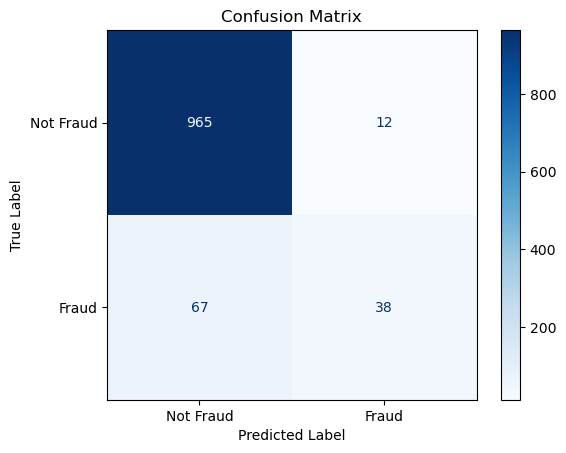

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

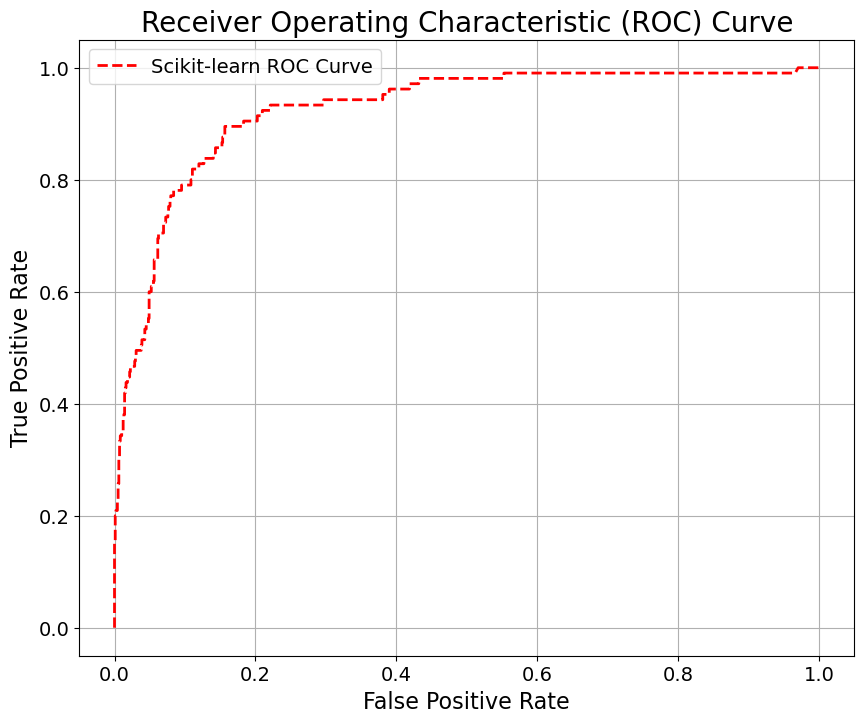

In [20]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'Scikit-learn ROC Curve') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

In [21]:
from sklearn.metrics import auc
# Area Under Curve
auc(fpr, tpr)

np.float64(0.9241994443632109)

In [32]:
# Create a DataFrame with predictions and actual values
roc_df = pd.DataFrame({
    'true_label': y_test.values,
    'pred_prob': y_predict # my guess?
})
roc_df.head(10)

,true_label,pred_prob
0,0,0
1,0,0
2,0,0
3,0,0
4,0,1
5,0,0
6,0,0
7,1,1
8,0,0
9,0,0


In [33]:
# Sort by predicted probability in descending order
roc_df = roc_df.sort_values('pred_prob', ascending=False).reset_index(drop=True)
# Display the first few rows to understand the data
print("Step 1: Sorted predictions by probability")
roc_df.head(10)

Step 1: Sorted predictions by probability


,true_label,pred_prob
0,1,1
1,1,1
2,1,1
3,1,1
4,0,1
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1


In [34]:
# Step 2: Calculate TPR and FPR at each possible threshold
# Initialize columns for counts and rates
roc_df['threshold'] = roc_df['pred_prob']  # Each row's probability becomes a potential threshold
roc_df['TP'] = 0
roc_df['FP'] = 0
roc_df['FN'] = 0
roc_df['TN'] = 0
roc_df['TPR'] = 0.0
roc_df['FPR'] = 0.0

In [35]:
roc_df.head(10)

,true_label,pred_prob,threshold,TP,FP,FN,TN,TPR,FPR
0,1,1,1,0,0,0,0,0.0,0.0
1,1,1,1,0,0,0,0,0.0,0.0
2,1,1,1,0,0,0,0,0.0,0.0
3,1,1,1,0,0,0,0,0.0,0.0
4,0,1,1,0,0,0,0,0.0,0.0
5,1,1,1,0,0,0,0,0.0,0.0
6,1,1,1,0,0,0,0,0.0,0.0
7,1,1,1,0,0,0,0,0.0,0.0
8,1,1,1,0,0,0,0,0.0,0.0
9,1,1,1,0,0,0,0,0.0,0.0


In [37]:
# Calculate actual counts of positives and negatives
n_pos = sum(roc_df['true_label'] == 1)
n_neg = sum(roc_df['true_label'] == 0)
print(f"Total positive examples (fruad = fraud): {n_pos}")
print(f"Total negative examples: {n_neg}")

Total positive examples (fruad = fraud): 105
Total negative examples: 977


In [38]:
# Step 3: For each threshold (row in our sorted df), calculate confusion matrix values
for i in range(len(roc_df)):
    # At this threshold, predictions for indices >= i are positive
    # and predictions for indices < i are negative
    threshold = roc_df.loc[i, 'threshold']
    # Calculate TP, FP, FN, TN for this threshold
    preds = (roc_df['pred_prob'] >= threshold).astype(int)
    TP = sum((preds == 1) & (roc_df['true_label'] == 1))
    FP = sum((preds == 1) & (roc_df['true_label'] == 0))
    FN = sum((preds == 0) & (roc_df['true_label'] == 1))
    TN = sum((preds == 0) & (roc_df['true_label'] == 0))
    # Calculate TPR and FPR
    TPR = TP / n_pos if n_pos > 0 else 0
    FPR = FP / n_neg if n_neg > 0 else 0
    # Store values
    roc_df.loc[i, 'TP'] = TP
    roc_df.loc[i, 'FP'] = FP
    roc_df.loc[i, 'FN'] = FN
    roc_df.loc[i, 'TN'] = TN
    roc_df.loc[i, 'TPR'] = TPR
    roc_df.loc[i, 'FPR'] = FPR

In [39]:
roc_df

,true_label,pred_prob,threshold,TP,FP,FN,TN,TPR,FPR
0,1,1,1,41,12,64,965,0.390476,0.012282
1,1,1,1,41,12,64,965,0.390476,0.012282
2,1,1,1,41,12,64,965,0.390476,0.012282
3,1,1,1,41,12,64,965,0.390476,0.012282
4,0,1,1,41,12,64,965,0.390476,0.012282
...,...,...,...,...,...,...,...,...,...
1077,0,0,0,105,977,0,0,1.000000,1.000000
1078,0,0,0,105,977,0,0,1.000000,1.000000
1079,0,0,0,105,977,0,0,1.000000,1.000000
1080,0,0,0,105,977,0,0,1.000000,1.000000


In [40]:
# Step 4: Add the (0,0) point explicitly for plotting
roc_points = roc_df[['FPR', 'TPR']].copy()
roc_points.head(5)

,FPR,TPR
0,0.012282,0.390476
1,0.012282,0.390476
2,0.012282,0.390476
3,0.012282,0.390476
4,0.012282,0.390476


In [41]:
# Add the (0,0) point - when threshold > max probability
roc_points.loc[-1] = [0, 0]
roc_points

,FPR,TPR
0,0.012282,0.390476
1,0.012282,0.390476
2,0.012282,0.390476
3,0.012282,0.390476
4,0.012282,0.390476
...,...,...
1078,1.000000,1.000000
1079,1.000000,1.000000
1080,1.000000,1.000000
1081,1.000000,1.000000


In [42]:
roc_points = roc_points.sort_index().reset_index(drop=True)
roc_points

,FPR,TPR
0,0.000000,0.000000
1,0.012282,0.390476
2,0.012282,0.390476
3,0.012282,0.390476
4,0.012282,0.390476
...,...,...
1078,1.000000,1.000000
1079,1.000000,1.000000
1080,1.000000,1.000000
1081,1.000000,1.000000


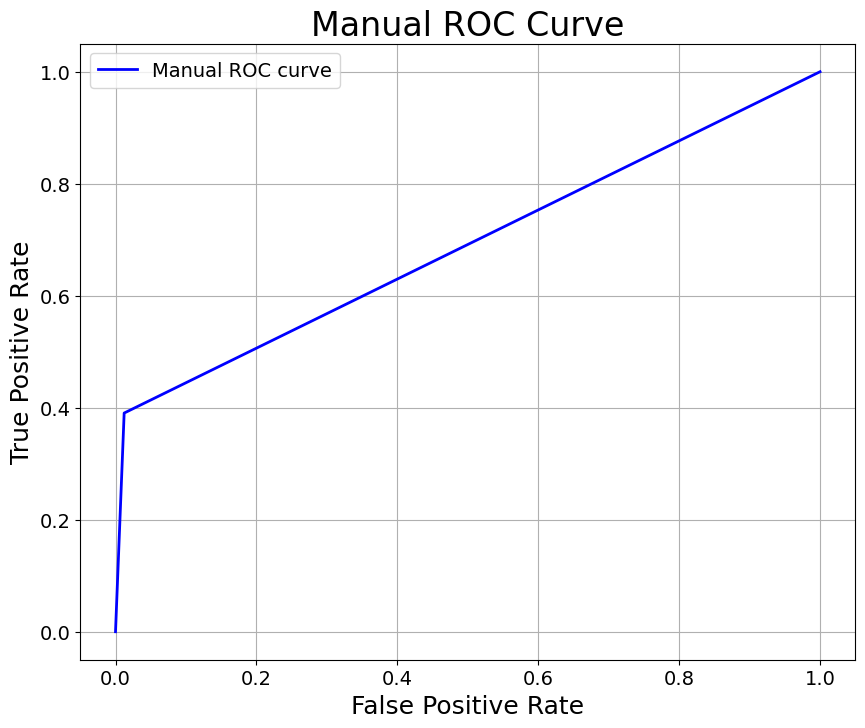

In [43]:
# Step 5: Plot the manually calculated ROC curve
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(roc_points['FPR'], roc_points['TPR'], 'b-', lw=2, label='Manual ROC curve')
# Set title with larger font size
ax.set_title('Manual ROC Curve', fontsize=24)
# Set axis labels with custom font sizes
ax.set_xlabel('False Positive Rate', fontsize=18)
ax.set_ylabel('True Positive Rate', fontsize=18)
# Set tick label sizes
ax.tick_params(axis='both', which='major', labelsize=14)
# Set legend font size
ax.legend(fontsize=14)
ax.grid(True)
plt.show()


### loooking for a better threshold to find better f1 score:

In [26]:
# Get predicted probabilities
y_proba = model.predict_proba(X_test)[:, 1]

In [27]:
precicions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

f1_scores = 2 * (precicions * recalls) / (precicions + recalls)
best_threshold = thresholds[f1_scores.argmax()]
print(f"Optimal threshold based on F1-score: {best_threshold}")

Optimal threshold based on F1-score: 0.09487004250756263


In [28]:
# apply the new best threshold to the predicted probabilities
y_pred_custom = (y_proba >= best_threshold).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_custom)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[904  73]
 [ 26  79]]


In [29]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
print('Confusion Matrix before manipulating by adding the threshold:\n')
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred_custom) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Confusion Matrix before manipulating by adding the threshold:

Accuracy: 0.91
Precision: 0.52
Recall: 0.75
F1 Score: 0.61
